# Classification Origin

In [ ]:
import csv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Import the colormap module
import folium
from scipy.spatial import Voronoi
import geopandas as gpd
import seaborn as sns

C:\Users\claud\AppData\Local\Temp\ipykernel_7948\3773353103.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


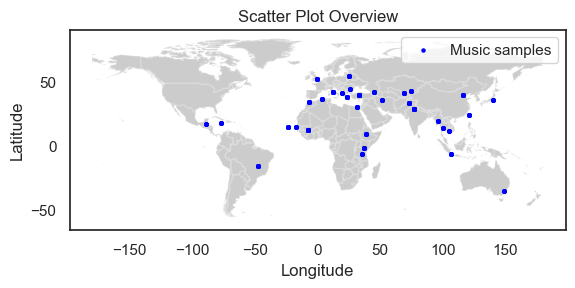

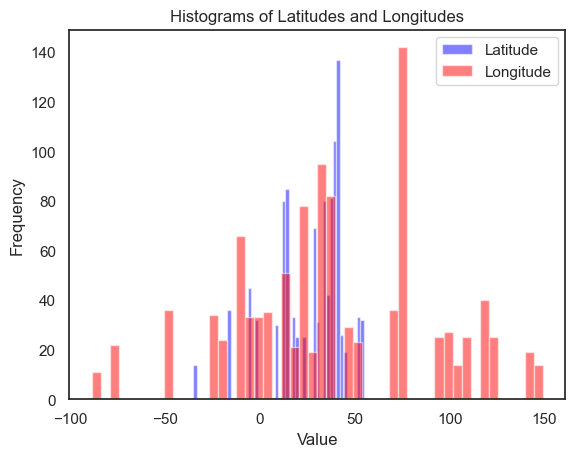

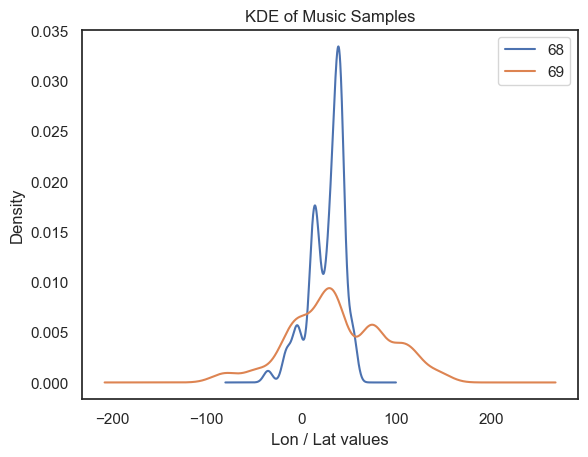

In [256]:
with open('./data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))
gdf = gpd.read_file('./data/countries/world-administrative-boundaries.shp')

data = pd.DataFrame(data)
data[68] = data[68].astype(float) #latitude
data[69] = data[69].astype(float) #longitude

#calculate number of points per long/lat:




gdf.plot(ax=plt.gca(), color='black', alpha=0.2, label='Shapefile')
plt.scatter(data[69], data[68], s=5, color = "blue",label = 'Music samples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot Overview')
plt.legend()
plt.show()


plt.hist(data[68], bins=50, alpha=0.5, color='blue', label='Latitude')
plt.hist(data[69], bins=50, alpha=0.5, color='red', label='Longitude')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Latitudes and Longitudes')
plt.show()


data.plot.kde()
plt.xlabel('Lon / Lat values')
plt.title('KDE of Music Samples')
plt.show()

In [271]:
per_lon = data.groupby(68).nunique().reset_index().sort_values(68)[[68,0]]


TypeError: Can only merge Series or DataFrame objects, a <class 'list'> was passed

In [158]:
import pgeocode
import requests

data["country"] = None

for i in range(len(data)):
    print(f"{i}\t out of {len(data)}")
    latitude = str(data[68][i])
    longitude = str(data[69][i])
    text = requests.get(f"http://api.geonames.org/countryCode?lat={latitude}&lng={longitude}&username=clauwi").text.rstrip()
    if text == "ERR:15:no country code found":
        text = "NOVAL"
    data["country"][i] = text

0	 out of 1059
1	 out of 1059
2	 out of 1059
3	 out of 1059


C:\Users\claud\AppData\Local\Temp\ipykernel_7948\301282975.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["country"][i] = text


4	 out of 1059
5	 out of 1059
6	 out of 1059
7	 out of 1059
8	 out of 1059
9	 out of 1059
10	 out of 1059
11	 out of 1059
12	 out of 1059
13	 out of 1059
14	 out of 1059
15	 out of 1059
16	 out of 1059
17	 out of 1059
18	 out of 1059
19	 out of 1059
20	 out of 1059
21	 out of 1059
22	 out of 1059
23	 out of 1059
24	 out of 1059
25	 out of 1059
26	 out of 1059
27	 out of 1059
28	 out of 1059
29	 out of 1059
30	 out of 1059
31	 out of 1059
32	 out of 1059
33	 out of 1059
34	 out of 1059
35	 out of 1059
36	 out of 1059
37	 out of 1059
38	 out of 1059
39	 out of 1059
40	 out of 1059
41	 out of 1059
42	 out of 1059
43	 out of 1059
44	 out of 1059
45	 out of 1059
46	 out of 1059
47	 out of 1059
48	 out of 1059
49	 out of 1059
50	 out of 1059
51	 out of 1059
52	 out of 1059
53	 out of 1059
54	 out of 1059
55	 out of 1059
56	 out of 1059
57	 out of 1059
58	 out of 1059
59	 out of 1059
60	 out of 1059
61	 out of 1059
62	 out of 1059
63	 out of 1059
64	 out of 1059
65	 out of 1059
66	 out of 105

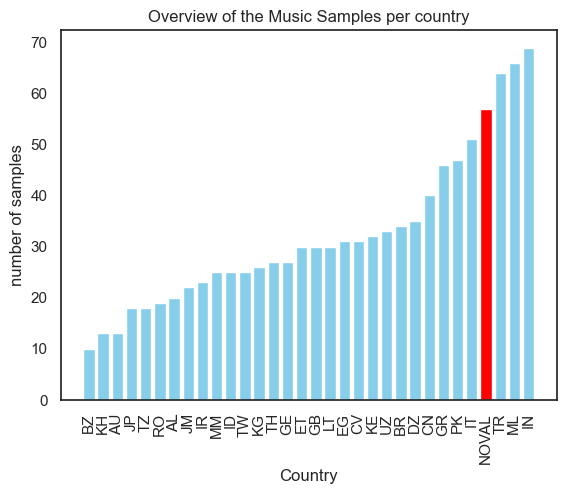

In [206]:
data2 = data[data['country'] != "ERR:19:the hourly limit of 1000 credits for clauwi has been exceeded. Please throttle your requests or use the commercial service."]
per_country = data2.groupby('country')[0].nunique().reset_index().sort_values(0)

plt.bar(per_country["country"],per_country[0], color = "skyblue")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per country")
plt.ylabel("number of samples")
plt.xlabel("Country")
plt.bar(per_country[per_country["country"]=="NOVAL"]["country"],per_country[per_country["country"]=="NOVAL"][0], color = "red")
plt.show()